In [36]:
from tok import Newname
import numpy as np
import random

dataset = Newname() 
tokens = dataset.tokens
num_words = len(tokens)

num_words

106328

In [2]:
def w2v_wrapper(model, w2i, word_vecs, dataset, block_size, loss_and_grad):
    batch_size = 50
    loss = 0.0
    grad = np.zeros(word_vecs.shape)
    N = word_vecs.shape[0]
    center_word_vecs = word_vecs[: int(N / 2), :]
    outside_word_vecs = word_vecs[int(N / 2) :, :]
    for i in range(batch_size):
        block_size1 = random.randint(1, block_size)
        result = dataset.get_random_context(block_size1)
        
        if callable(result):
            continue
        
        center_word, context = result

        c, grad_in, grad_out = model(
            center_word,
            block_size1,
            context,
            w2i,
            center_word_vecs,
            outside_word_vecs,
            dataset,
            loss_and_grad,
        )
        loss += c / batch_size
        grad[: int(N / 2), :] += grad_in / batch_size
        grad[int(N / 2) :, :] += grad_out / batch_size

    return loss, grad

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [3]:
def softmax(x):
    """Compute the softmax function for each row of the input x.

    Arguments:
    x -- A D dimensional vector or N x D dimensional numpy matrix.
    Return:
    x -- You are allowed to modify x in-place
    """
    orig_shape = x.shape

    if len(x.shape) > 1:
        # Matrix
        tmp = np.max(x, axis=1)
        x -= tmp.reshape((x.shape[0], 1))
        x = np.exp(x)
        tmp = np.sum(x, axis=1)
        x /= tmp.reshape((x.shape[0], 1))
    else:
        # Vector
        tmp = np.max(x)
        x -= tmp
        x = np.exp(x)
        tmp = np.sum(x)
        x /= tmp

    assert x.shape == orig_shape
    return x

In [5]:
# normal softmax
def softmaxloss_gradient(center_word_vec, outside_word_idx, outside_word_vecs, dataset):
    dot_products = np.dot(outside_word_vecs, center_word_vec)
    softmax_probs = softmax(dot_products)
    loss = -np.log(softmax_probs[outside_word_idx])

    grad_center_vec = -outside_word_vecs[outside_word_idx] + np.dot(
        softmax_probs, outside_word_vecs
    )
    grad_outside_vecs = np.outer(softmax_probs, center_word_vec)
    grad_outside_vecs[outside_word_idx] -= center_word_vec

    return loss, grad_center_vec, grad_outside_vecs

In [6]:
def get_negative_samples(outsideWordIdx, dataset, K):
    """Samples K indexes which are not the outsideWordIdx"""

    negSampleWordIndices = [None] * K
    for k in range(K):
        newidx = dataset.sampleTokenIdx()
        while newidx == outsideWordIdx:
            newidx = dataset.sampleTokenIdx()
        negSampleWordIndices[k] = newidx
    return [int(n) for n in negSampleWordIndices]

In [7]:
# negative sampling
def negative_samplingloss_gradient(
    center_word_vec, outside_word_idx, outside_word_vecs, dataset, K=10
):
    neg_samples = get_negative_samples(outside_word_idx, dataset, K)

    grad_center_vec = np.zeros(center_word_vec.shape)
    grad_outside_vecs = np.zeros(outside_word_vecs.shape)

    u_0 = outside_word_vecs[outside_word_idx]
    z_0 = np.dot(u_0, center_word_vec)
    p_0 = sigmoid(z_0)
    loss = -np.log(p_0)

    grad_center_vec += (p_0 - 1) * u_0
    grad_outside_vecs[outside_word_idx] += (p_0 - 1) * center_word_vec

    for k in neg_samples:
        u_k = outside_word_vecs[k]
        z_k = np.dot(u_k, center_word_vec)
        p_k = sigmoid(-z_k)
        loss -= np.log(p_k)

        grad_center_vec -= (p_k - 1) * u_k
        grad_outside_vecs[k] -= (p_k - 1) * center_word_vec

    return loss, grad_center_vec, grad_outside_vecs

In [8]:
def skipgram(
    current_center_word,
    block_size1,
    outside_words,
    w2i,
    center_word_vecs,
    outside_word_vecs,
    dataset,
    loss_and_grad,
):
    loss = 0.0
    grad_center_vecs = np.zeros(center_word_vecs.shape)
    grad_outside_vecs = np.zeros(outside_word_vecs.shape)

    center_word_idx = w2i[current_center_word]
    center_word_vec = center_word_vecs[center_word_idx]

    for outside_word in outside_words:
        outside_word_idx = w2i[outside_word]
        current_loss, current_grad_center_vec, current_grad_outside_vecs = (
            loss_and_grad(center_word_vec, outside_word_idx, outside_word_vecs, dataset)
        )
        loss += current_loss
        grad_center_vecs[center_word_idx] += current_grad_center_vec
        grad_outside_vecs += current_grad_outside_vecs

    return loss, grad_center_vecs, grad_outside_vecs

In [9]:
import pickle
import glob
import random
import numpy as np
import os.path as op

SAVE_PARAMS_EVERY = 2000


def load_saved_params():
    """
    A helper function that loads previously saved parameters and resets
    iteration start.
    """
    st = 0
    for f in glob.glob("saved_params_*.npy"):
        iter = int(op.splitext(op.basename(f))[0].split("_")[2])
        if iter > st:
            st = iter

    if st > 0:
        params_file = "saved_params_%d.npy" % st
        state_file = "saved_state_%d.pickle" % st
        params = np.load(params_file)
        with open(state_file, "rb") as f:
            state = pickle.load(f)
        return st, params, state
    else:
        return st, None, None


def save_params(iter, params):
    params_file = "saved_params_%d.npy" % iter
    np.save(params_file, params)
    with open("saved_state_%d.pickle" % iter, "wb") as f:
        pickle.dump(random.getstate(), f)


losses = []


def sgd(f, x0, step, iterations, use_saved=False, PRINT_EVERY=10):
    ANNEAL_EVERY = 5000
    if use_saved:
        start_iter, oldx, state = load_saved_params()
        if start_iter > 0:
            x0 = oldx
            step = 0.0
        if state:
            random.setstate(state)
    else:
        start_iter = 0

    x = x0
    exploss = None

    for iter in range(start_iter + 1, iterations + 1):
        loss = None
        loss, gradient = f(x)
        x -= step * gradient

        if exploss is None:
            exploss = loss
        else:
            exploss = 0.95 * exploss + 0.05 * loss

        if iter % PRINT_EVERY == 0:
            if not exploss:
                exploss = loss
            else:
                exploss = 0.95 * exploss + 0.05 * loss
            print("iter %d: %f" % (iter, exploss))
            losses.append(exploss)

        if iter % SAVE_PARAMS_EVERY == 0 and use_saved:
            save_params(iter, x)

        if iter % ANNEAL_EVERY == 0:
            step *= 0.5

    return x

In [35]:
import time
import matplotlib.pyplot as plt

vector_dim = 150
C = 5

random.seed(31415)
np.random.seed(9265)

start_time = time.time()
word_vecs = np.concatenate(
    (
        (np.random.rand(num_words, vector_dim) - 0.5) / vector_dim,
        np.zeros((num_words, vector_dim)),
    ),
    axis=0,
)
word_vecs = sgd(
    lambda vec: w2v_wrapper(
        skipgram, tokens, vec, dataset, C, negative_samplingloss_gradient
    ),
    word_vecs,
    step=1,
    iterations=10000,
    use_saved=True,
    PRINT_EVERY=10,
)

print("training took %d seconds" % (time.time() - start_time))

KeyboardInterrupt: 

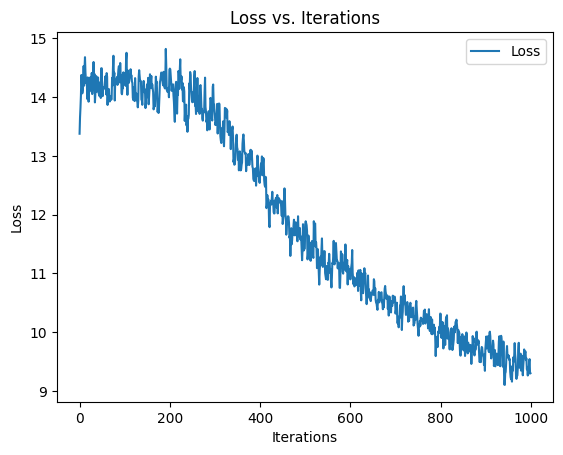

<function logging.makeLogRecord(dict)>

In [ ]:
from logging import makeLogRecord

plt.plot(losses, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss vs. Iterations")
plt.legend()
plt.show()
makeLogRecord

In [15]:
trained_word_vectors = np.concatenate(
    (word_vecs[:num_words, :], word_vecs[num_words:, :]), axis=0
)  # put all of center word vecs together

In [34]:
freq = 3000
visualize_words = [w for w in dataset.tok_freq if dataset.tok_freq[w] > freq ]
visualize_idx = [tokens[word] for word in visualize_words]

len(visualize_words)

120

In [26]:
# dimension reduction for visualization
visualize_vecs = trained_word_vectors[visualize_idx, :]
temp = visualize_vecs - np.mean(visualize_vecs, axis=0)
covariance = 1.0 / len(visualize_idx) * temp.T.dot(temp)
U, S, V = np.linalg.svd(covariance)
coord = temp.dot(U[:, 0:2])
full_piece = temp.dot(U[:, 0:2])

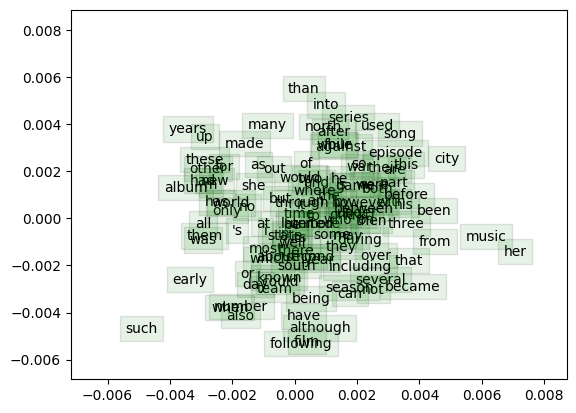

NameError: name 'makeLogRecord' is not defined

In [33]:
import matplotlib.pyplot as plt

for i in range(len(visualize_words)):
    plt.text(
        coord[i, 0],
        coord[i, 1],
        visualize_words[i],
        bbox=dict(facecolor="green", alpha=0.1),
    )

plt.xlim((np.min(coord[:, 0]), np.max(coord[:, 0])))
plt.ylim((np.min(coord[:, 1]), np.max(coord[:, 1])))
plt.show()
makeLogRecord